# 11. 레이블되지 않은 데이터 다루기: 군집 분석
## 11.1 k-평균 알고리즘을 사용하여 유사한 객체 그룹핑

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,
                  n_features=2,
                  centers=3,
                  cluster_std=0.5,
                  shuffle=True,
                  random_state=0)

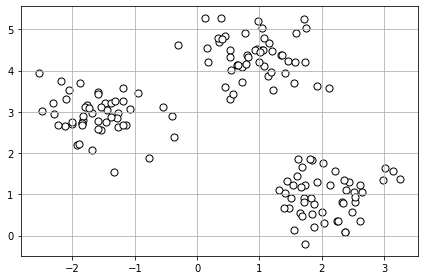

In [2]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0],
            X[:, 1],
            c='white',
            marker='o',
            edgecolor='black',
            s=50)
plt.grid()
plt.tight_layout()
plt.show()

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

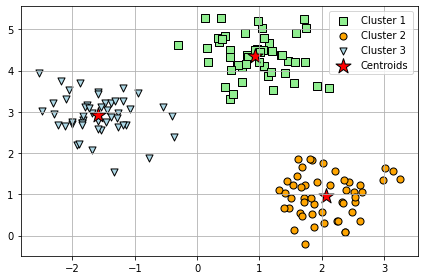

In [4]:
# 시각화
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

In [5]:
# Elbow 방법 - 최적의 클러스터 개수 찾기
print('왜곡: %.2f' % km.inertia_)

왜곡: 72.48


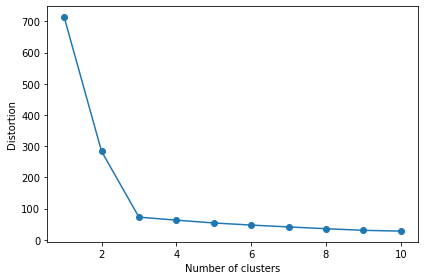

In [6]:
# Elbow graph
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

In [7]:
# Silhouette graph
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

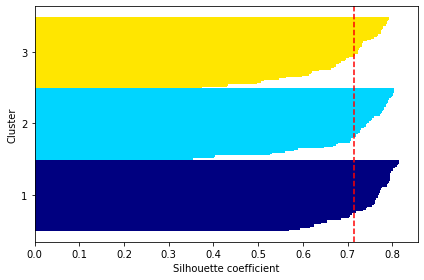

In [8]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X,
                                     y_km,
                                     metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color='red',
            linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

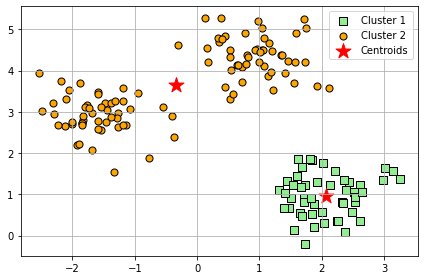

In [9]:
# 잘 clustering을 못하는 경우 산점도와 실루엣 그래프가 어떤가 보자
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*', c='red',
            label='Centroids')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

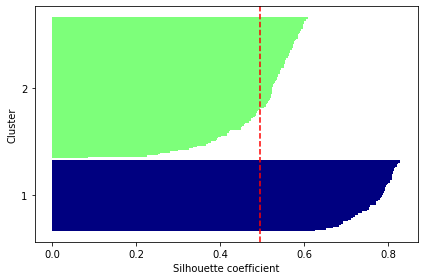

In [10]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0,
             edgecolor='none',
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(c_silhouette_vals)
plt.axvline(silhouette_avg, color='red', linestyle='--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()
plt.show()

## 11.2 계층적인 트리로 클러스터 조직화

* 덴드로그램 - 이진 트리 형태로 계층 군집을 시각화
* 클러스터 개수를 미리 지정할 필요 없음
* 분할 군집 - 전체 샘플을 포함하는 하나의 클러스터에서 시작하여 더 작은 클러스터로 반복적으로 나눔
* 병합 군집 - 각 샘플이 독립적인 클러스터가 되고 하나의 클러스터가 남을 때까지 가장 가까운 클러스터를 합침

In [11]:
# 예제를 위한 랜덤한 샘플 데이터 만들기
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5, 3]) * 10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [12]:
# 거리 행렬 계산
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(
    pdist(df, metric='euclidean')),
                        columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [13]:
# 완전 연결 병합을 적용
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(pdist(df, metric='euclidean'),
                       method='complete')

In [14]:
# pandas dataframe으로 나타내기
pd.DataFrame(row_clusters,
             columns=['row label 1',
                      'row label 2',
                      'distance',
                      'no. of items in clust.'],
             index=['cluster %d' %(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


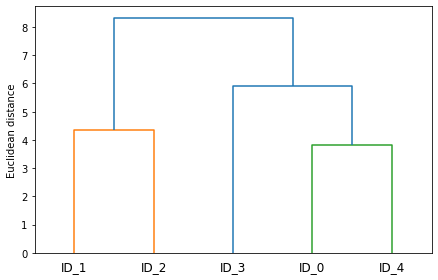

In [15]:
# 덴드로그램 그리기
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters,
                       labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

/var/folders/rw/qhxpv8ld5lz_zd0bxydq952w0000gn/T/ipykernel_32381/2561672427.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_xticklabels([''] + list(df_rowclust.columns))
/var/folders/rw/qhxpv8ld5lz_zd0bxydq952w0000gn/T/ipykernel_32381/2561672427.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_yticklabels([''] + list(df_rowclust.index))


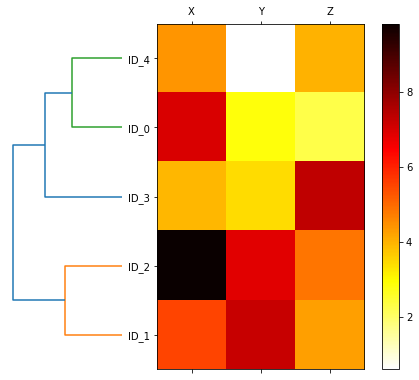

In [16]:
# 히트맵에 덴드로그램 연결
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust,
                  interpolation='nearest', cmap='hot_r')

axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()

In [17]:
# 11.2.4 사이킷런에서 병합 군집 적용
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean',
                             linkage='complete')
labels = ac.fit_predict(X)
print('클러스터 레이블: %s' % labels)

클러스터 레이블: [1 0 0 2 1]


## 11.3 DBSCAN을 사용하여 밀집도가 높은 지역 찾기

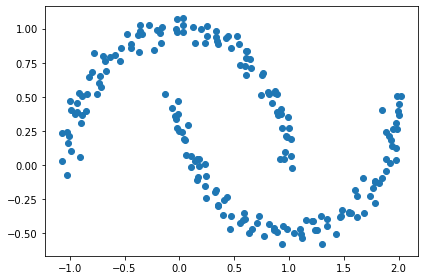

In [18]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200,
                  noise=0.05,
                  random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()